# Preparation

In [1]:
!pip3 install pandas
!pip3 install matplotlib

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple

#plt.style.use('seaborn-white')

In [2]:
# helper functions

style_ = namedtuple("style_", ["color", "marker", "linestyle"])

def load_csv_files(csv_files):
    dfs = {}
    for key, fname in csv_files.items():
        df = pd.read_csv(fname)
        dfs[key] = df[df["Skipped"] == "No"]
    return dfs

def filter_bench(dfs, query):
    if isinstance(dfs, dict):
        filtered_dfs = {}
        for key in dfs.keys():
            filtered_dfs[key] = dfs[key].query(query)
        return filtered_dfs
    else:
        return dfs.query(query)

def plot_bench(dfs, xlabel, styles, show_legend=True, title=None, ofname=None, show_xlabel=True, show_ylabel=True, log_xscale=False, log_yscale=False, font_size=14):
    fig, ax = plt.subplots(1, 1)

    ax.tick_params(labelsize=font_size)
    if(show_ylabel):
        ax.set_xlabel(xlabel, fontsize=font_size)
    if(show_ylabel):
        ax.set_ylabel("Operations per second", fontsize=font_size)
    if(log_xscale):
        ax.set_xscale('log')
    if(log_yscale):
        ax.set_yscale('log')
    ax.set_title(title, fontsize=font_size)
    ax.grid()

    for key, df in dfs.items():        
        style = styles[key]

        Y = df["NumInputs"].unique()[0]/df["GPU Time (sec)"]

        if xlabel in df.columns:
            X = df[xlabel]
    
            ax.plot(X, Y, label=key, color=style.color, marker=style.marker, linestyle=style.linestyle)
            ax.scatter(X, Y, color=style.color, marker=style.marker, linestyle=style.linestyle)
        else:
            ax.axhline(y=Y.iloc[0], label=key, color=style.color, linestyle=style.linestyle)

    if(show_legend):
        plt.legend(fontsize=font_size - 4)

    if(ofname):
        plt.savefig(ofname, dpi=1200, format='png', bbox_inches='tight')

    plt.show()

INSERT/CONTAINS on V100/A100 (GMEM)


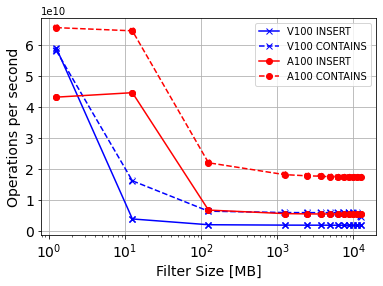

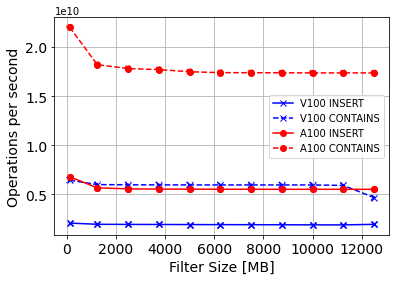

In [8]:
# GMEM
dfs = load_csv_files({"V100" : "../results/bloom_filter_v100.csv", 
                      "A100" : "../results/bloom_filter_a100.csv"})
                          
dfs["V100"]["Filter Size [MB]"] = dfs["V100"]["NumBits"] / 8 / 1000 / 1000
dfs["A100"]["Filter Size [MB]"] = dfs["A100"]["NumBits"] / 8 / 1000 / 1000

dfs["V100 INSERT"] = dfs["V100"].query('Operation == "INSERT"')
dfs["V100 CONTAINS"] = dfs["V100"].query('Operation == "CONTAINS"')
dfs["A100 INSERT"] = dfs["A100"].query('Operation == "INSERT"')
dfs["A100 CONTAINS"] = dfs["A100"].query('Operation == "CONTAINS"')
del dfs["V100"]
del dfs["A100"]

styles = {
    "V100 INSERT" : style_('b', 'x', '-'),
    "V100 CONTAINS" : style_('b', 'x', '--'),
    "A100 INSERT" : style_('r', 'o', '-'),
    "A100 CONTAINS" : style_('r', 'o', '--')}

query = 'Skipped   == "No" and\
         KeyType   == "I32" and\
         SlotType  == "I32" and\
         NumHashes == 2 and\
         NumInputs == 1000000000'

print("INSERT/CONTAINS on V100/A100 (GMEM)")
plot_bench(filter_bench(dfs, query), "Filter Size [MB]", styles=styles, log_xscale=True)

query = query + ' and NumBits > 100000000'
plot_bench(filter_bench(dfs, query), "Filter Size [MB]", styles=styles)

INSERT on A100 (GMEM vs. L2)


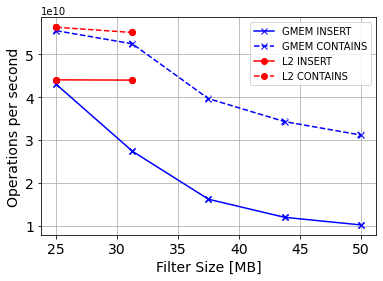

In [9]:
# GMEM vs. L2
df = pd.read_csv("../results/bloom_filter_scope_hit_ratio_60.csv")
df = df[df["Skipped"] == "No"]
df["Filter Size [MB]"] = df["NumBits"] / 8 / 1000 / 1000

dfs = {}
dfs["GMEM INSERT"] = df.query('Scope == "GMEM" and Operation == "INSERT"')
dfs["GMEM CONTAINS"] = df.query('Scope == "GMEM" and Operation == "CONTAINS"')
dfs["L2 INSERT"] = df.query('Scope == "L2" and Operation == "INSERT"')
dfs["L2 CONTAINS"] = df.query('Scope == "L2" and Operation == "CONTAINS"')

styles = {
    "GMEM INSERT" : style_('b', 'x', '-'),
    "GMEM CONTAINS" : style_('b', 'x', '--'),
    "L2 INSERT" : style_('r', 'o', '-'),
    "L2 CONTAINS" : style_('r', 'o', '--')}
    
query = 'KeyType   == "I32" and\
         SlotType  == "I32" and\
         NumHashes == 2 and\
         NumInputs == 50000000'

print("INSERT on A100 (GMEM vs. L2)")
plot_bench(filter_bench(dfs, query), "Filter Size [MB]", styles=styles)